## ***Introduction***

This notebook provides a comprehensive guide to creating and training a deeo learning model using
Tensorflow and keras. The focus os on a food classification task using a subset of the Food-101
dataset, which contains images of 10 different food classes. The following key steps are covered:

* 1 *Data Preparation*
   * Utilize `ImageDataGnerator` for processing data.
   * Load training and testing datasets from specified directories.
* 2 *Model Building* 
  * Use pre-trained modeks frim TensorFlow Hub feature extraction.
  * Build a custom Keras Sequential model leveraging these pre-trained models.
* 3 *Training and Evaluation*
  * Compile the model with appropriate loss functions, optimizers, and metrics.
  * Train the model on the training data and validate it on the testing data.
  * Implementing TensorBoard for monitoring the training process.     

  By employing transfer learning with pre-trained model such as ResNet and EfficientNet,
  the process leverages their learned features, making model traning more efficient and
  potentially more accurate even with a limited amount of data. This approach aims to 
  provide a clear understanding of how to preprocess image data, build deep learning
  model using TensorFlow Hub, and evaluate its performance. 



In [1]:
import tensorflow as tf
import zipfile
import os
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt 

### Retrieve the data

In [3]:
zip_ref  = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [4]:

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directorie and {len(filenames)} images in '{dirpath}'")

There are 2 directorie and 0 images in '10_food_classes_10_percent'
There are 10 directorie and 0 images in '10_food_classes_10_percent\test'
There are 0 directorie and 250 images in '10_food_classes_10_percent\test\chicken_curry'
There are 0 directorie and 250 images in '10_food_classes_10_percent\test\chicken_wings'
There are 0 directorie and 250 images in '10_food_classes_10_percent\test\fried_rice'
There are 0 directorie and 250 images in '10_food_classes_10_percent\test\grilled_salmon'
There are 0 directorie and 250 images in '10_food_classes_10_percent\test\hamburger'
There are 0 directorie and 250 images in '10_food_classes_10_percent\test\ice_cream'
There are 0 directorie and 250 images in '10_food_classes_10_percent\test\pizza'
There are 0 directorie and 250 images in '10_food_classes_10_percent\test\ramen'
There are 0 directorie and 250 images in '10_food_classes_10_percent\test\steak'
There are 0 directorie and 250 images in '10_food_classes_10_percent\test\sushi'
There are 

### Creating data loaders (preparing the data)

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode="categorical")
print("Testing images:")
test_dat_10_percent = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


### Setting up callbacks

* Tracking experiments with TensorBord callback
* Model checkpoint with ModelCheckpoint callback
* Stopping a model from training with the EarlyStopping callback

In [30]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M&%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback


### Creatung models using Tensorflow Hub

In [15]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [12]:
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub IRL and creates a Keras Sequential model with it.
    Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
    should be equal to number of target classes, default 10.
    Returns: 
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
    """
    feature_extractor_layer = hub.KerasLayer(model_url, 
                                             trainable=False, # Freeze the already learned patterns 
                                             name="feature_extraction_layer",
                                             input_shape=IMAGE_SHAPE+(3,))
    
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])    
    return model



In [20]:
# Creating ResNet Tensorflow model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

In [21]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [31]:
resnet_hisotry = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  validation_data=test_dat_10_percent,
                                  callbacks=[create_tensorboard_callback(dir_name="tensorlow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorlow_hub/resnet50V2/20240714-1546&06
Epoch 1/5
24/24 [==============================] - 16s 471ms/step - loss: 1.9051 - accuracy: 0.3427 - val_loss: 1.2189 - val_accuracy: 0.6148
Epoch 2/5
24/24 [==============================] - 4s 168ms/step - loss: 0.8802 - accuracy: 0.7373 - val_loss: 0.8480 - val_accuracy: 0.7284
Epoch 3/5
24/24 [==============================] - 4s 167ms/step - loss: 0.6113 - accuracy: 0.8200 - val_loss: 0.7563 - val_accuracy: 0.7620
Epoch 4/5
24/24 [==============================] - 4s 169ms/step - loss: 0.4793 - accuracy: 0.8680 - val_loss: 0.7097 - val_accuracy: 0.7752
Epoch 5/5
24/24 [==============================] - 4s 170ms/step - loss: 0.3828 - accuracy: 0.9160 - val_loss: 0.6939 - val_accuracy: 0.7732


In [38]:
# Plot the validation amd training curves
def plot_loss_curves(history):
    """
    Returns sepatate loss curves for training and validation metrics.

    Args:
    history: TensorFlow History object.

    Returns:
    Plots of training/validation loss and accuracy metrics.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

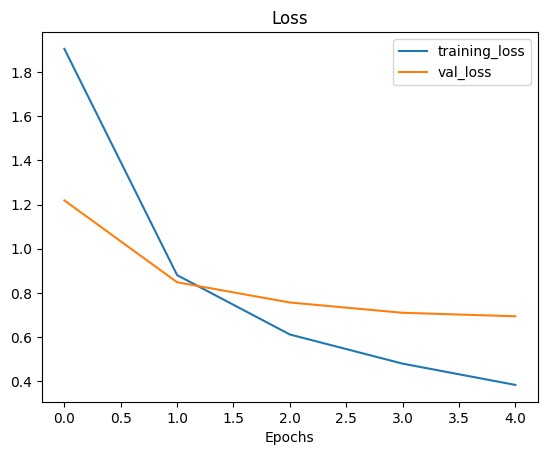

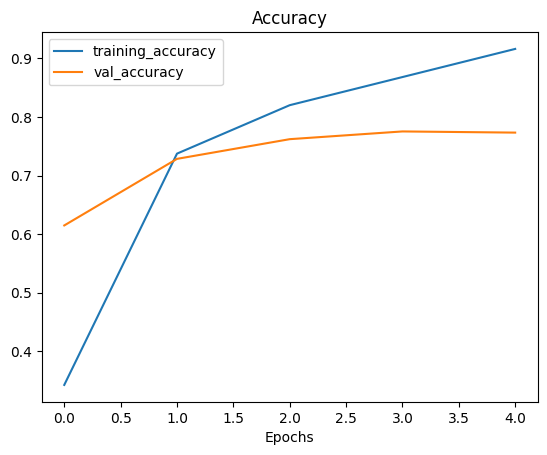

In [39]:
plot_loss_curves(resnet_hisotry)

### Creating and testing EfficientNetB0 Hub Extraction model


In [43]:
# Create EfficientNetB0 model
efficientnet_model = create_model(model_url=efficientnet_url, num_classes=train_data_10_percent.num_classes)

# Compile EfficientNetModel
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.optimizers.Adam(),
                           metrics=["accuracy"])
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              validation_data=test_dat_10_percent,
                                              epochs=5,
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficentnetb0")])


Saving TensorBoard log files to: tensorflow_hub/efficentnetb0/20240714-1706&49
Epoch 1/5
24/24 [==============================] - 9s 195ms/step - loss: 1.8178 - accuracy: 0.4733 - val_loss: 1.2556 - val_accuracy: 0.7504
Epoch 2/5
24/24 [==============================] - 4s 177ms/step - loss: 1.0406 - accuracy: 0.7947 - val_loss: 0.8415 - val_accuracy: 0.8280
Epoch 3/5
24/24 [==============================] - 4s 176ms/step - loss: 0.7415 - accuracy: 0.8453 - val_loss: 0.6822 - val_accuracy: 0.8468
Epoch 4/5
24/24 [==============================] - 4s 176ms/step - loss: 0.5952 - accuracy: 0.8760 - val_loss: 0.5994 - val_accuracy: 0.8604
Epoch 5/5
24/24 [==============================] - 4s 177ms/step - loss: 0.5023 - accuracy: 0.8947 - val_loss: 0.5485 - val_accuracy: 0.8648


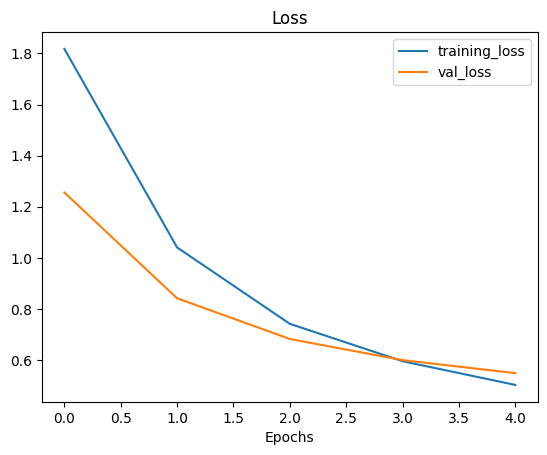

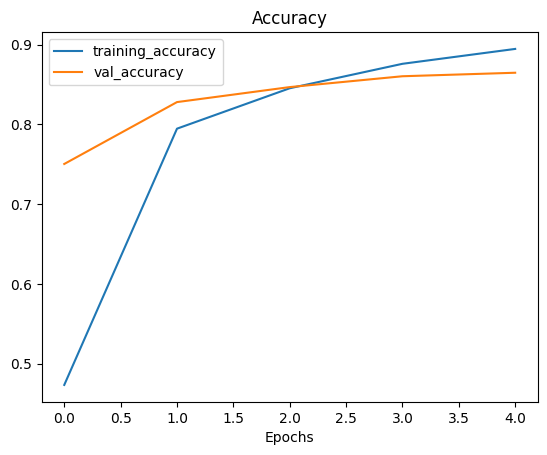

In [45]:
plot_loss_curves(efficientnet_history)

In [49]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [50]:
efficientnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________
